In [82]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import coffea.hist as hist
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams.update({'font.size': 16})
import scipy
import math
import numba
import bitstruct as bitstruct

In [83]:
def getDataRaw(fname):
    data = []
    format=bitstruct.compile("p4u12u12u12u12u12"*(256*int(30/5)))
    swapformat="8"*(256*int(30/5))
    with open(fname, "rb") as f:
        line = f.read((1+4+int(256*30/5))*8)
        while len(line) == (1+4+int(256*30/5))*8:
            data.extend(format.unpack(bitstruct.byteswap(swapformat, line[5*8:])))
            line = f.read((1+4+int(256*30/5))*8)
    data = np.array(data)
    return data.reshape([-1, 30, 256])

def getData(fnames):
    data = []
    for fname in fnames:
        with open(fname) as f:
            for line in f:
                data.extend(line.split()[1:31])
    data = np.array(data, dtype='float')
    return data.reshape([-1, 256, 30])    

In [84]:
ped_data = getDataRaw("testData/cal_newSetup_1.txt")
data = getDataRaw("testData/sin_newSetup_all_2.txt")#getData(["Data_20200312_030712.txt",])
#sineData = getData(["Data_20200312_034047.txt", "Data_20200312_034055.txt"])

In [85]:
#averages = np.zeros(ped_data.mean(0).shape)
averages = ped_data.mean(0)
stddevs = ped_data.std(0)
#averages = averages.transpose()

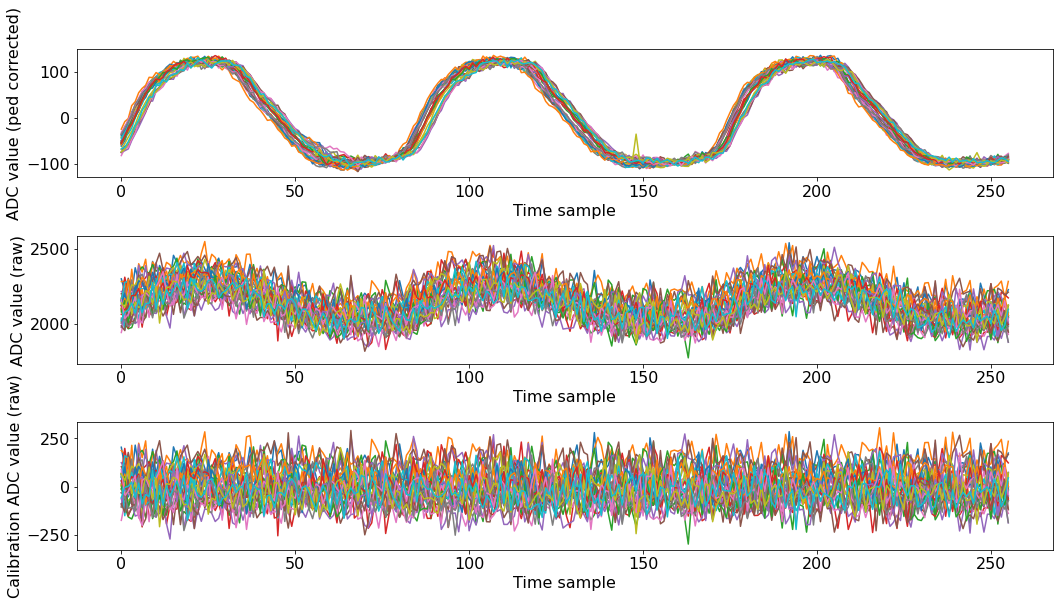

In [86]:
def sine(x, A, B, omega, phi):
    return A * np.sin(omega*x + phi) + B

#channel_pulse = np.array([5, 11,17,23,29])
#channel_pulse = np.array([3,24,])
#channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
event = 1

xdata = np.linspace(0, 255,256)
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:]
ydata_pulse_cal = ped_data[event,channel_pulse,:] - ped_data[event,channel_pulse,:].mean()


#popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/5, 0.0))
#popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:200], ydata[0:200], p0=popt)
#print(*popt)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

#plt.plot(data[1,channel,2:]-data[1,channel,2:].mean())
#plt.plot(xdata, ydata_raw, label="data")
#ax1.plot(xdata, ydata, label="250 MHz sine")
#ax1.plot(xdata, sine(xdata, *popt), label="sine fit")
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="Pulse %i"%i)
#ax1.legend(loc="lower right")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

#ax2.plot(xdata, ydata_raw, label="250 MHz sine")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

for i, d in enumerate(ydata_pulse_cal):
    ax3.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax3.set_xlabel("Time sample")
ax3.set_ylabel("Calibration ADC value (raw)")

fig.tight_layout()



In [12]:
channel = 5
channel_pulse = np.array([11,17,23,29])
event = 400


xdata = np.linspace(0, 255,256)
ydata_pulse = sineData[event,:,channel_pulse]-averages[:,channel_pulse].transpose()
ydata_pulse_raw = sineData[event,:,channel_pulse] - sineData[event,:,channel].mean()

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(xdata, ydata, label="250 MHz sine (WR ZEN 1)")
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="250 MHz sine %i (WR ZEN 2)"%i)
#ax1.legend(loc="lower right")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

ax2.plot(xdata, ydata_raw, label="250 MHz sine (WR ZEN 1)")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="250 MHz sine %i (WR ZEN 2)"%i)
ax2.legend(loc="upper right")
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

fig.tight_layout()

NameError: name 'sineData' is not defined

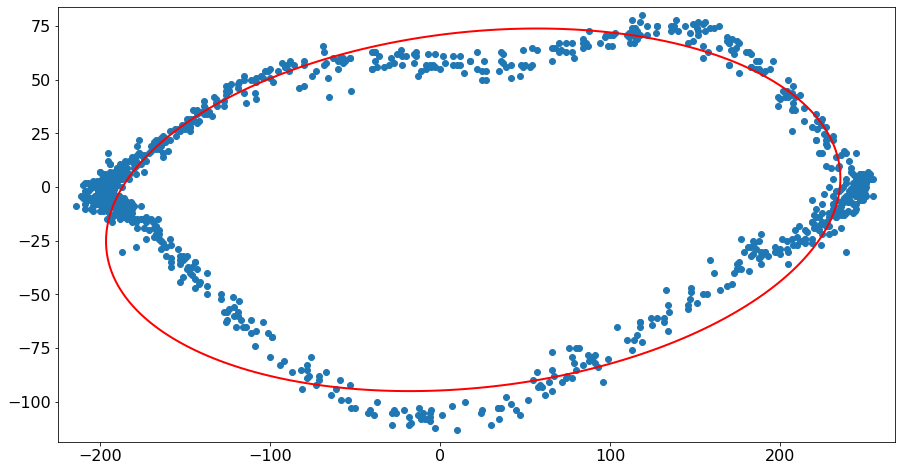

In [89]:
sineData = data
ydata = sineData-averages
#ydata = linDat

timeOffsets = []

for iCap in range(256):

    cap1 = iCap
    cap2 = (iCap+1)%256
    channel = 11

    x = ydata[:,channel, cap2] + ydata[:,channel, cap1]
    y = ydata[:,channel, cap1] - ydata[:,channel, cap2]

    #y = y[(x > 1200) | (x < -1200)]
    #x = x[(x > 1200) | (x < -1200)]
    #y = y[(x > 4) | (x < 2.3)]
    #x = x[(x > 4) | (x < 2.3)]

    # Formulate and solve the least squares problem ||Ax - b ||^2
    A = np.column_stack([x**2, x * y, y**2, x, y])
    b = np.ones_like(x)
    fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
    #print(fit)

    try:
        a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
        #print("a = %f"%a)
        b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
        #print("b = %f"%b)

        dtij = math.atan(b/a)/(math.pi*250000000.0)
        #print("dtij = %f ps"%(dtij*1e12))
        timeOffsets.append(dtij)
    except:
        timeOffsets.append(100.0e-12)

timeOffsets = np.array(timeOffsets)
#plt.plot(ydata[0,:,5])
plt.scatter(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

a = 2041.434647
b = 172.292351
dtij = 107.204409 ps
angle = -0.014512



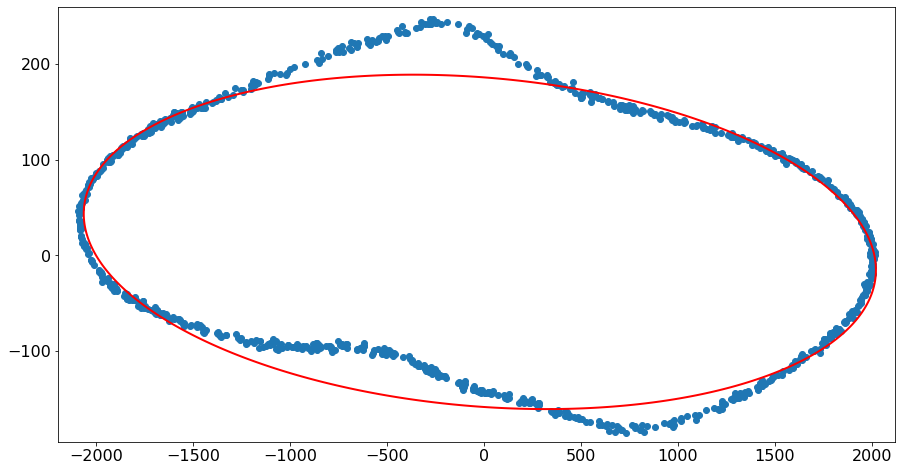

In [ ]:
ydata = sineData-averages
#ydata = linDat

cap1 = 25
cap2 = 26
channel = 11

x = ydata[:,cap2,channel] + ydata[:,cap1,channel]
y = ydata[:,cap1,channel] - ydata[:,cap2,channel]
#x = ydata[:,cap2,11] + ydata[:,cap1,17]
#y = ydata[:,cap1,17] - ydata[:,cap2,11]

y_fit = y[(x > 1300) | (x < -1300)]
x_fit = x[(x > 1300) | (x < -1300)]

#y_fit = y[(x > 1.6) | (x < 0.9)]
#x_fit = x[(x > 1.6) | (x < 0.9)]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
b = np.ones_like(x_fit)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

tmp_a = max(a,b)
tmp_b = min(a,b)
a = tmp_a
b = tmp_b

dtij = math.atan(b/a)/(math.pi*250000000.0)
print("dtij = %f ps"%(dtij*1e12))
#print(timeOffsets[cap1:cap2].sum()*1e12)

theta = math.atan((fit[2]-fit[0]-math.sqrt((fit[2]-fit[0])**2+fit[1]**2))/fit[1])
print("angle = %f\n"%(theta))

plt.scatter(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x.min() if x.min() < 0 else 0.95*x.min(),1.05*x.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

a = 19.938347
b = 1.569182
dtij = 100.000000 ps
angle = -0.000000



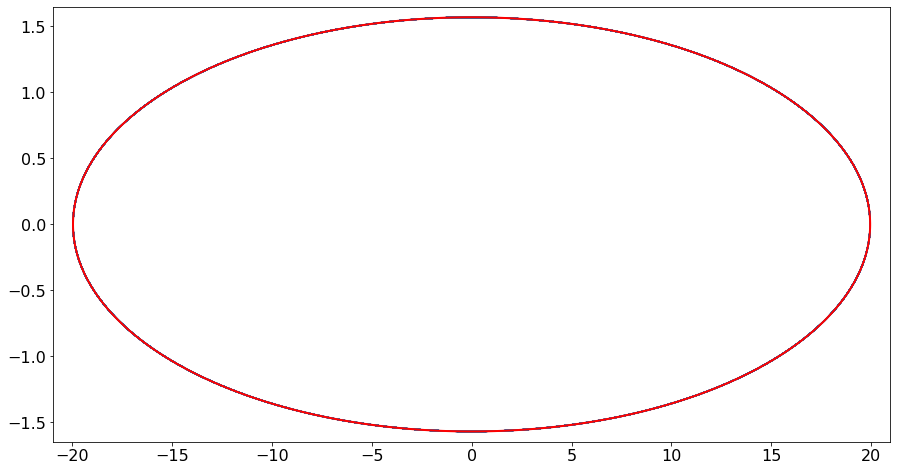

In [ ]:
def func(t, A, fin, phi, P):
    a = A*np.sin(2*math.pi*fin*t + phi)
    return a

A1 = 10
A2 = 10
fin1 = 250e6
fin2 = 250e6
phi1 = 0
phi2 = 0
P1 = 1
P2 = 1.1

t=np.linspace(0, 100e-9, 100000)
dt = 100e-12
x = func(t,      A1, fin1, phi1, P1) + func(t + dt, A2, fin2, phi2, P2)
y = func(t + dt, A2, fin2, phi2, P2) - func(t,      A1, fin1, phi1, P1)

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x**2, x * y, y**2, x, y])
b = np.ones_like(x)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

dtij = math.atan(min((a,b))/max((a,b)))/(math.pi*fin1)
print("dtij = %f ps"%(dtij*1e12))

theta = math.atan((fit[2]-fit[0]-math.sqrt((fit[2]-fit[0])**2+fit[1]**2))/fit[1])
print("angle = %f\n"%theta)

plt.plot(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

Text(0.5, 0, 'time offsets (ps)')

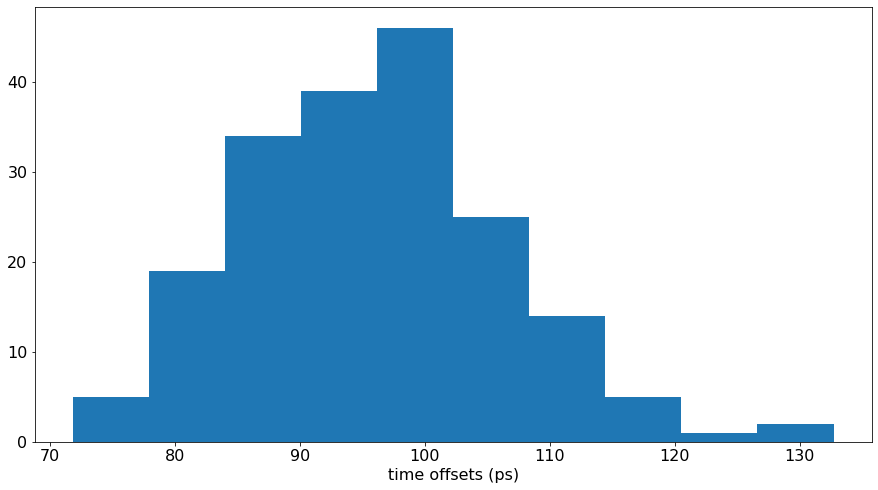

In [ ]:
plt.hist(timeOffsets[:190]*1e12)
plt.xlabel("time offsets (ps)")

Text(0.5, 0, 'timesample')

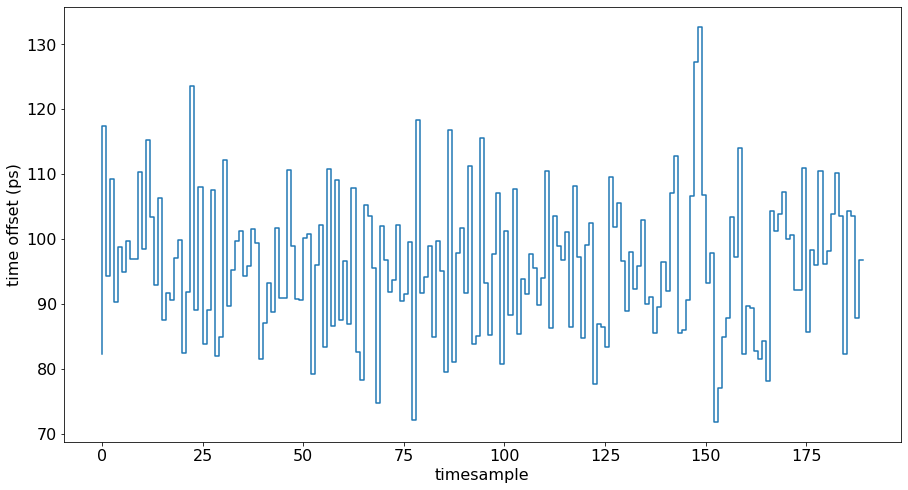

In [ ]:
plt.step(np.linspace(0, 189, 190), timeOffsets[:190]*1e12)
plt.ylabel("time offset (ps)")
plt.xlabel("timesample")

[ 0.55504864 -0.01459959  5.29814465 -0.07663249  0.01247214]
a = 1.344045
b = 0.435023
dtij = 398.557083 ps


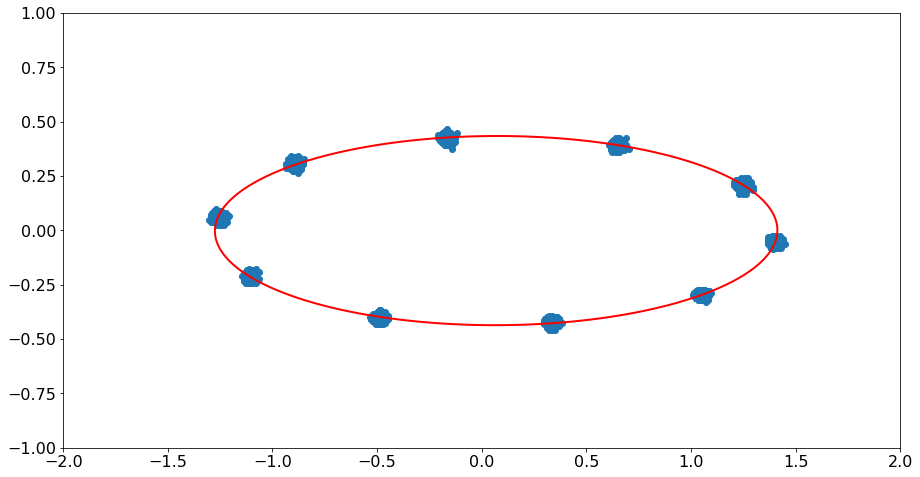

In [ ]:
x_tsdata = []
y_tsdata = []
with open("tek0002CH2.csv") as f:
    for line in f:
        vals = line.split(",")
        if(len(vals) == 2):
            x_tsdata.append(float(vals[0]))
            y_tsdata.append(float(vals[1]))

x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)
            
x = y_tsdata[:-1] + y_tsdata[1:]
y = y_tsdata[:-1] - y_tsdata[1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x**2, x * y, y**2, x, y])
b = np.ones_like(x)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
print(fit)

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

dtij = math.atan(b/a)/(math.pi*250000000.0)
print("dtij = %f ps"%(dtij*1e12))
plt.scatter(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(-2,2,300)
y_coord = np.linspace(-1,1,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

0.70537521876794 0.03907925869442077 1570997526.1660066 144.78334959035158


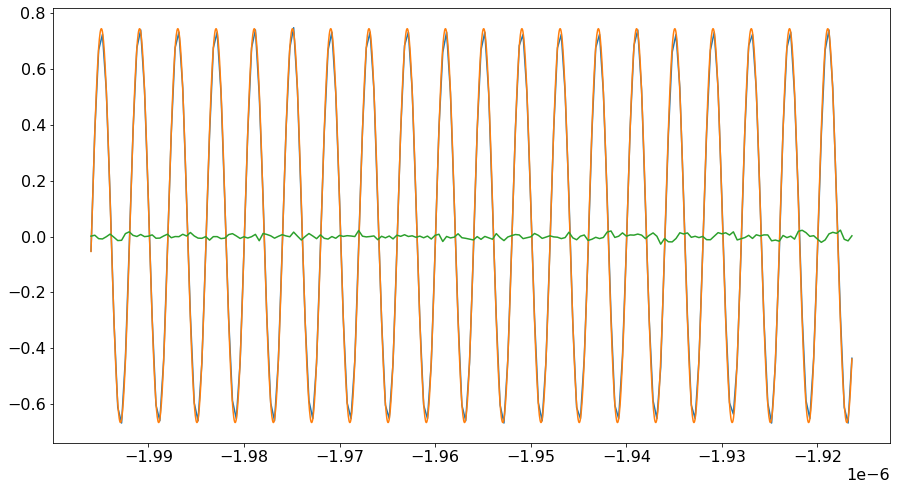

In [ ]:
x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)

popt=(0.75, 0.0, 1.50/1e-9, 0.0)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[50:60], y_tsdata[50:60], p0=popt)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[0:100], y_tsdata[0:100], p0=popt)
print(*popt)

diff = y_tsdata - sine(x_tsdata, *popt)

plt.plot(x_tsdata[:200], y_tsdata[:200])

x_sim = np.linspace(x_tsdata[:200].min(), x_tsdata[:200].max(), 2000)
plt.plot(x_sim, sine(x_sim, *popt), label="sine fit")

plt.plot(x_tsdata[:200], diff[:200])

(1000, 30, 256) 58.86100664300046


Text(0.5, 0, 'Pedestal ADC')

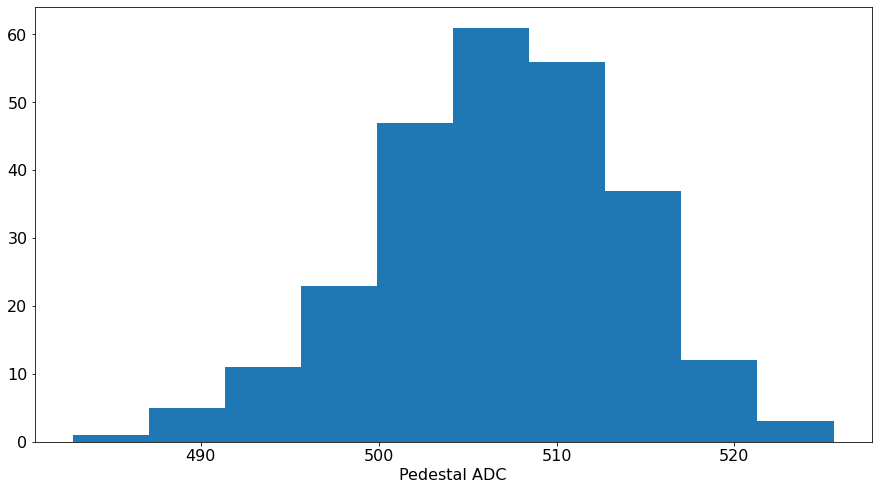

In [ ]:
pdl = getDataRaw("data/Raw_PedScan_%i_b3.txt"%0x0a00)

print(pdl.shape, pdl[0,11,:].std())
plt.hist(pdl[0,11,:]-averages[:,11])
plt.xlabel("Pedestal ADC")
#plt.plot(pdl[0,11,:]-averages[:,11])

In [ ]:
means = []
x_vals = [i for i in range(0x10, 0xfff, 0x10)]
for i in x_vals:
    if i % 0x100 == 0: print(i)
    pedData = getDataRaw("data/Raw_PedScan_%i_b0.txt"%i)
    means.append(pedData.mean(0))

256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840


Text(0, 0.5, 'measured ADC')

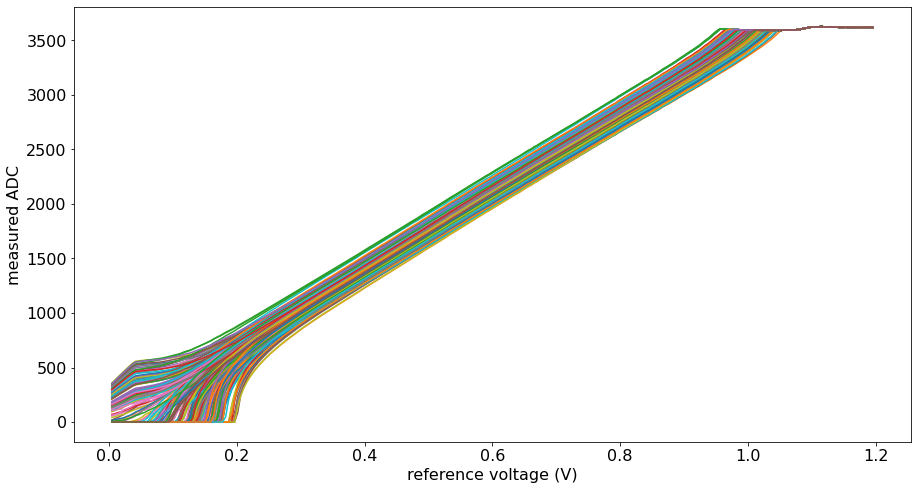

In [ ]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

channel = 20

for i in range(256):
    meanList = np.array([mean[channel,i] for mean in means])
    plt.plot(refVoltage, meanList)
    
plt.xlabel("reference voltage (V)")
plt.ylabel("measured ADC")

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except(ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [ ]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

def lineraize_wrap(f, val):
    try:
        return f(val)
    except(ValueError):
        if val < 2000:
            return 0
        else:
            return 3.3

vlineraize_wrap = np.vectorize(lineraize_wrap)
        
voltageLin = []
for j in range(0, 30):
    voltageLin.append([])
    for i in range(0, 256):
        meanList = np.array([mean[j,i] for mean in means])
        meanList = savitzky_golay(meanList, 41, 2)
        voltageLin[j].append(scipy.interpolate.interp1d(meanList, refVoltage))
        

In [ ]:
xv = np.array([acd for acd in range(4096)])
yv = vlineraize_wrap(voltageLin[0][0], xv)

linDat = np.zeros_like(sineData)
for j in range(0, 30):
    for i in range(0, 256):
        linDat[:,i,j] = lineraize_wrap(voltageLin[j][i], sineData[:,i,j])

119.72853845662361 0.11466102124683018 0.07276931702927439 -2.7028042854282788
mse: 4.378808


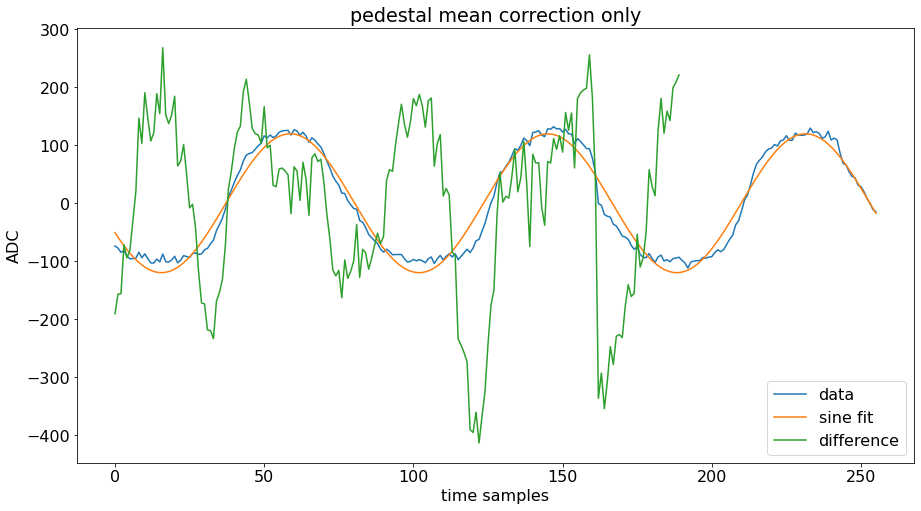

In [93]:
from scipy import optimize
event = 15
channel = 11

xdata = np.linspace(0, 255,256)
ydata = sineData[event,channel,:]-averages[channel, :]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
pmco_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("pedestal mean correction only")
plt.xlabel("time samples")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*1000, label="difference")

plt.legend(loc="lower right")

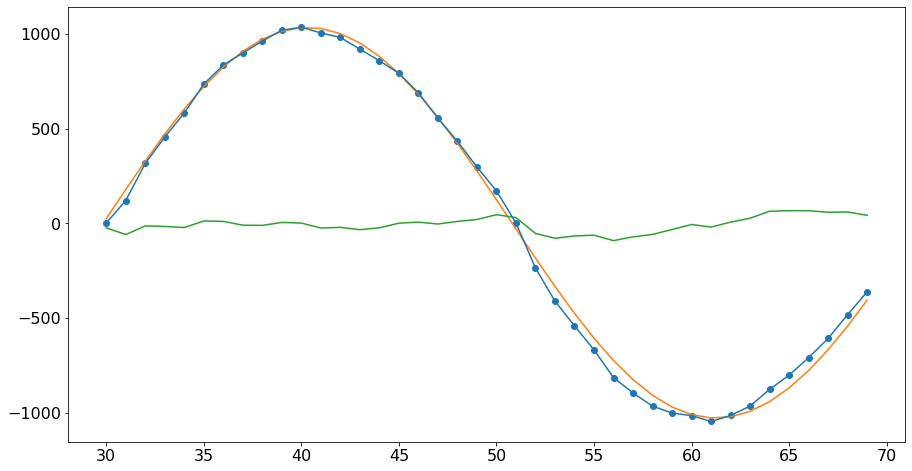

In [ ]:
plt.scatter(xdata[30:70], ydata[30:70], label="data")
plt.errorbar(xdata[30:70], ydata[30:70], yerr=3, label="data")

plt.plot(xdata[30:70], sine(xdata[30:70], *popt), label="sine fit")

plt.plot(xdata[30:70], diff[30:70]*popt[0], label="difference")

0.30806317596168076 0.6015586391613927 -0.15014382165853152 13.90860405468833
mse: 0.450728


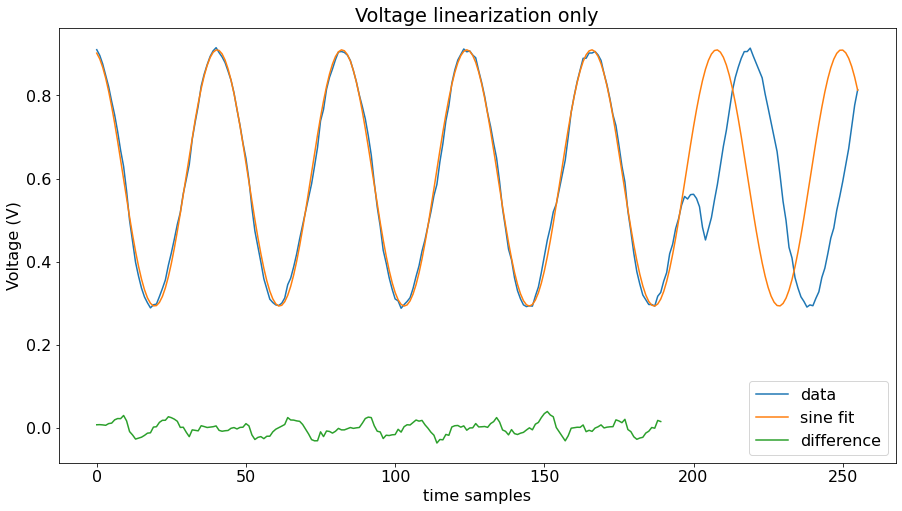

In [ ]:
xdata = np.linspace(0, 255,256)
#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, :, channel]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
vlo_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Voltage linearization only")
plt.xlabel("time samples")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

119.72853845662361 0.11466102124683018 0.07276931702927439 -2.7028042854282788
mse: 227.692253


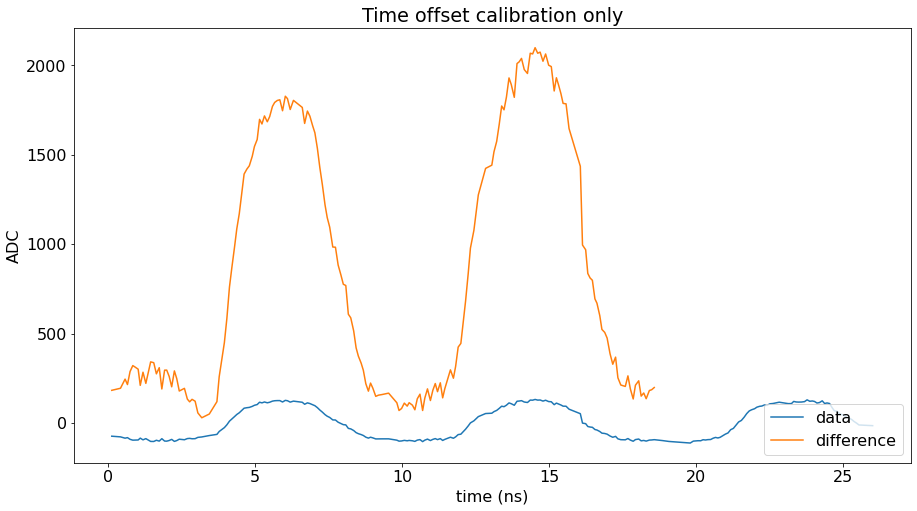

In [96]:
xdata = np.cumsum(timeOffsets)*1e9
ydata = sineData[event,channel,:]-averages[channel, :]
#ydata = linDat[event, :, 5]

#popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(400.0, 0.0, 1.0/5000, 0.0))
#popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset calibration only")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

#plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], np.abs(diff[:190]*1000), label="difference")

plt.legend(loc="lower right")

0.30721129658631996 0.5994629531264452 1.5745048426530697 -11.001931054749994
mse: 0.348352


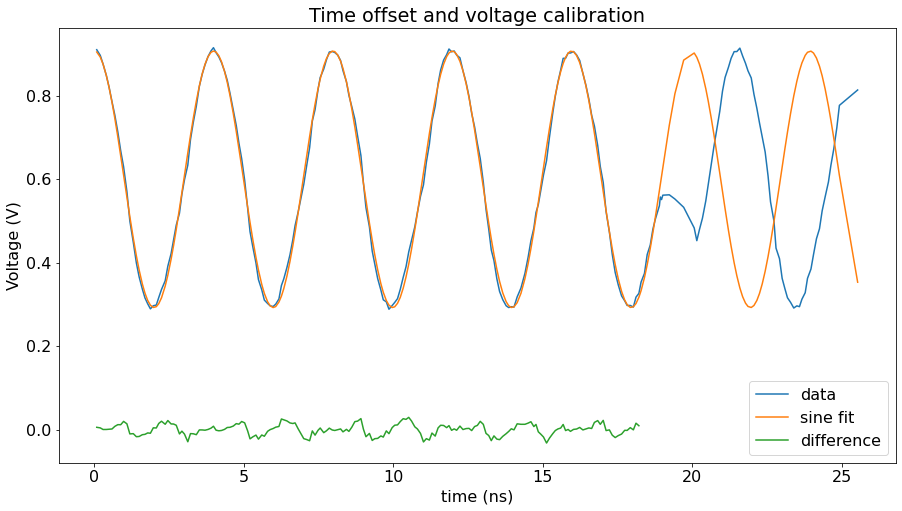

In [ ]:
xdata = np.cumsum(timeOffsets)*1e9
#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, :, channel]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/5000, 0.6))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/np.abs(popt[0])
all_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset and voltage calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

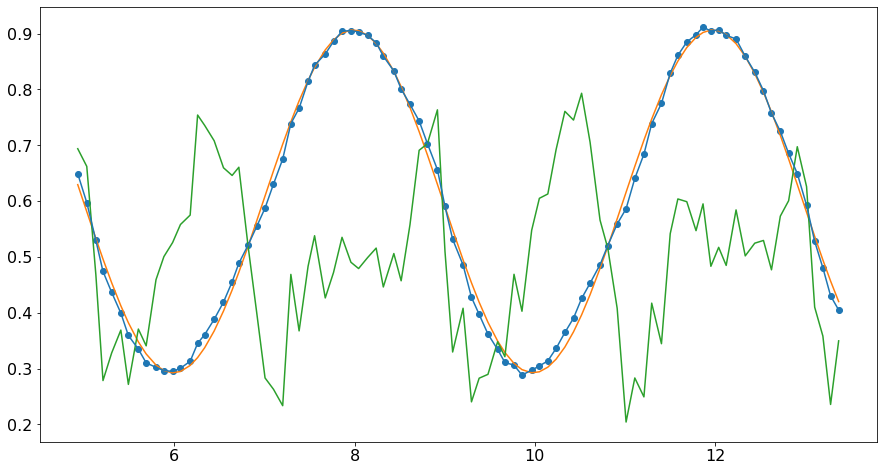

In [ ]:
t = 20
s = slice(30+t,120+t)

plt.scatter(xdata[s], ydata[s], label="data")
plt.errorbar(xdata[s], ydata[s], yerr=3*1.2/4096, label="data")

plt.plot(xdata[s], sine(xdata[s], *popt), label="sine fit")

plt.plot(xdata[s], diff[s]*popt[0]*10 + 0.5, label="difference")

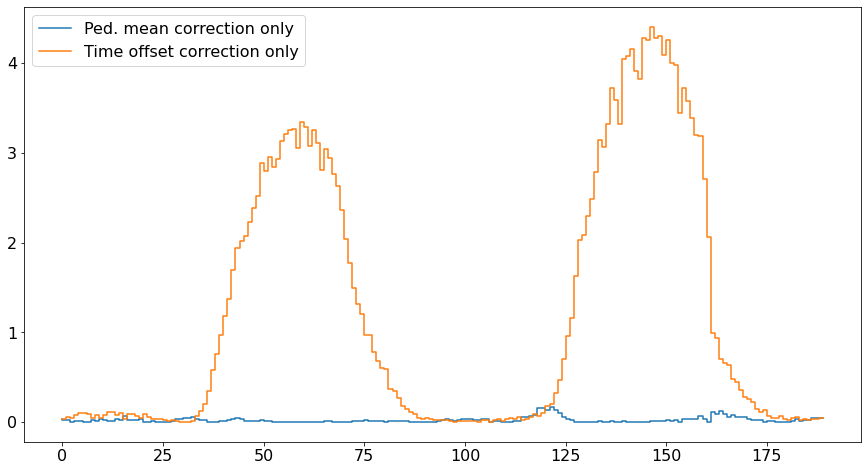

In [98]:
xdat = np.linspace(0, 189, 190)
plt.step(xdat,pmco_diff[:190]**2, label="Ped. mean correction only")
#plt.step(xdat,vlo_diff[:190]**2, label="Voltage linearization only")
plt.step(xdat,toco_diff[:190]**2, label="Time offset correction only")
#plt.step(xdat,all_diff[:190]**2, label="All corrections")
plt.legend()